# Pipeline

1. Preprocessing
2. Cosine Similarity / Nearest Neighbors
3. Build / Test Models

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
db_path = '../data/beer.db'
conn = sqlite3.connect(db_path)

query = "SELECT * FROM user_extract"
df = pd.read_sql(query, conn)

In [3]:
# 1. remove duplicates 
df = df[~df.duplicated()]

In [4]:
# 2. one-hot encode categorical variables
categorical_variables = ['beer_description', 'brewery']
for cat_var in categorical_variables:
    dummies = pd.get_dummies(df[cat_var], drop_first=True, prefix=cat_var)
    df = pd.merge(df, dummies, left_index=True, right_index=True)

In [5]:
# 4. flag outliers
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
skipnas = True

for feature in features:
    try:
        q1 = df[feature].quantile(.25)
        q3 = df[feature].quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
        outliers = df[~non_outlier_mask]

        print("FEATURE {}".format(feature))
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(df)))
        print("\n")
    except TypeError:
        print("FEATURE {}".format(feature))
        print("ANALYZING ALL NON-NA VALUES")
        
        non_nas = df[~df[feature].isna()][feature].astype(float)
        q1 = non_nas.quantile(.25)
        q3 = non_nas.quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (non_nas >= q1 - 1.5*iqr) & (non_nas <= q3 + 1.5*iqr)
        outliers = non_nas[~non_outlier_mask]
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(non_nas)))
        print("\n")

FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


FEATURE global_rating
num of outliers = 3,648
% of outliers = 3.56%


FEATURE user_rating
num of outliers = 11,267
% of outliers = 10.98%


FEATURE IBU
ANALYZING ALL NON-NA VALUES
num of outliers = 557
% of outliers = 1.00%




/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


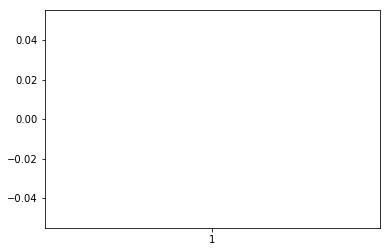

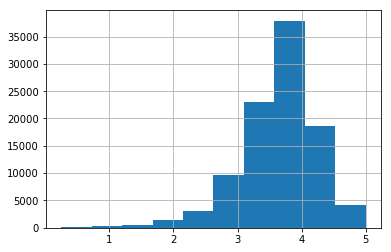

In [6]:
plt.boxplot(df['user_rating'])
plt.show()
df['user_rating'].hist()

In [7]:
# 4. Impute missing values 
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
impute_method = 'mean'

for feature in features:
    if impute_method == 'mean':
        non_nas = df[~df[feature].isna()][feature].astype(float)
        feature_mean = non_nas.mean()
        df[feature] = df[feature].fillna(feature_mean)

## 2. Cosine Similarity / Nearest Neighbors

In [8]:
# 1. Create User-Item Matrix 
fill_method = 'item_mean'

data = df
values = 'user_rating'
index = 'username'
columns = 'beer_name'
agg_func = 'mean'

if fill_method == 'item_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix = ui_matrix.fillna(ui_matrix.mean(axis=0), axis=0)

elif fill_method == 'user_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

elif fill_method == 0:
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func, fill_value=0)
else:
    raise ValueError("Please checkout 'fill_method' value")

ui_matrix.columns = list(ui_matrix.columns)

In [9]:
# 2. Scale / Standardize 
scale_standardize = 'standardize'

if scale_standardize == 'scale':
    print('Data is already scaled from 0 to 5')
elif scale_standardize == 'standardize':
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    standardized_ui_matrix = pd.DataFrame(scaler.fit_transform(ui_matrix))
    standardized_ui_matrix.index = ui_matrix.index
    standardized_ui_matrix.columns = ui_matrix.columns
    ui_matrix = standardized_ui_matrix
elif scale_standardize == None:
    print("Skipping scaling / standardization")
else:
    raise ValueError("Please checkout 'scale_standardize' value")

In [10]:
# Calculate Cosine Similarity 
user_of_reference = 'tsharp93'
print("User of Reference for Cosine Sim = {}".format(user_of_reference))

from sklearn.metrics.pairwise import cosine_similarity
X = ui_matrix[ui_matrix.index == user_of_reference]
Y = ui_matrix[ui_matrix.index != user_of_reference]

sim = cosine_similarity(X,Y)[0].tolist()
names = Y.index

sim_df = pd.DataFrame({'username':names, 'sim_score':sim})
sim_df = sim_df.sort_values(by='sim_score', ascending=False)

User of Reference for Cosine Sim = tsharp93


In [11]:
sim_df.head()

,username,sim_score
18,Gmlman,0.857681
34,Mikeylga,0.856230
39,MythicMan57,0.845642
94,junana71,0.842739
98,kwitnes,0.840310


In [12]:
# add neighbor rank to df
neighbor_rank = sim_df.reset_index(drop=True)
neighbor_rank.index.name = 'nearest_neighbor_rank'
neighbor_rank.reset_index(inplace=True)
neighbor_rank['nearest_neighbor_rank'] = neighbor_rank['nearest_neighbor_rank'] + 1
neighbor_rank = neighbor_rank[['nearest_neighbor_rank', 'username']]

In [13]:
neighbor_rank.head()

,nearest_neighbor_rank,username
0,1,Gmlman
1,2,Mikeylga
2,3,MythicMan57
3,4,junana71
4,5,kwitnes


In [14]:
print(df.shape)
df = pd.merge(neighbor_rank, df, on='username')
print(df.shape)

(102598, 8347)
(102558, 8348)


## 3. Build Models

### Select Features and Target

In [15]:
brewery_cols = [col for col in df if col.startswith('brewery_')]
beer_description_cols = [col for col in df if col.startswith('beer_description_')]

features = ['ABV', 'IBU', 'global_rating'] + beer_description_cols
target = 'user_rating'

print("REMINDER User of Reference = {}".format(user_of_reference))

REMINDER User of Reference = tsharp93


### Set Up Estimators and Grids

In [16]:
# import GridSearchCV and desired estimators
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVR

# empty estimator dictionary
estimator_dict = {}

# create models and grids 

# estimator = LinearRegression()
# grid = {}
# estimator_dict['linearregression'] = {'estimator':estimator, 'grid':grid}

estimator = ElasticNet()
grid = {
    'alpha': np.linspace(0.1, 1.0, 10),
    'l1_ratio': np.linspace(0.1, 1.0, 10),
    'fit_intercept': [True, False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


estimator = LinearSVR()
grid = {
    'epsilon': np.linspace(0.25/2, 0.5, 10),
    'C': np.linspace(1.0, 10, 10),
    'fit_intercept': [True, False],
    'max_iter': [100000]
}
estimator_dict['linearsvr'] = {'estimator':estimator, 'grid':grid}

### Set Scoring Metric

In [17]:
scoring = 'neg_mean_squared_error'

### Train/Test - Setup

In [18]:
def multiple_gridsearchCV(estimator_dict, X_train, y_train):
    
    # grid search for each estimator, store best params and scores for each estimator
    for key in estimator_dict.keys():
        
        # build gridsearchcv
        gridsearchcv = GridSearchCV(estimator = estimator_dict[key]['estimator'], 
                                    param_grid = estimator_dict[key]['grid'],
                                    cv=3, scoring=scoring, return_train_score=True, iid=True)

        # silence SVR convergence warnings 
        import warnings
        warnings.filterwarnings('ignore', 'Liblinear failed to converge,*')

        # fit gridsearchcv
        gridsearchcv.fit(X_train, y_train)

        # gather results 
        estimator_dict[key]['nearest_neighbors'] = 'ALL'
        estimator_dict[key]['n_training_points'] = len(X_train)
        estimator_dict[key]['best_params'] = gridsearchcv.best_params_
        estimator_dict[key]['neg_mean_squared_error'] = gridsearchcv.best_score_
        estimator_dict[key]['stdev'] = gridsearchcv.cv_results_['std_test_score'][gridsearchcv.best_index_]
        
        results_dict = estimator_dict

    return(results_dict)

In [19]:
# setup df to store all results 
all_results_df = pd.DataFrame({'nearest_neighbors':[], 'n_training_points':[], 
                              'best_params':[], 'neg_mean_squared_error':[]})

#### A. All Data

In [20]:
# store training data 
training_data = df

In [21]:
# # split data
# X_train = training_data[training_data['username'] != user_of_reference][features]
# y_train = training_data[training_data['username'] != user_of_reference][target]

# # train
# results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# # append results
# results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
#                                                    'best_params', 'neg_mean_squared_error']]
# all_results_df = all_results_df.append(results_df)

#### B. Sort by Nearest Neighbors, Take Top *N* Nearest Neighbors

In [25]:
# specify top_n range
top_n = 10

Prep Data by Methodology

In [26]:
# take top_n nearest neighbors
df_top_n = df[df['nearest_neighbor_rank'] <= top_n]

# store training data 
training_data = df_top_n

Train / Test

In [27]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results
results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
                                                   'best_params', 'neg_mean_squared_error']]
all_results_df = all_results_df.append(results_df)

View Results

In [28]:
all_results_df

,nearest_neighbors,n_training_points,best_params,neg_mean_squared_error
elasticnet,ALL,39.0,"{'alpha': 0.5, 'fit_intercept': True, 'l1_rati...",-0.42129
linearsvr,ALL,39.0,"{'C': 2.0, 'epsilon': 0.20833333333333331, 'fi...",-0.51786


#### C. Sort by Nearest Neigbors, Take Top *n_points*

In [29]:
# specify n_points
n_points = 10000

Prep Data by Methodology 

In [30]:
# sort by nearest neighbors
df_sorted = df.sort_values('nearest_neighbor_rank')

# take top n_points of sorted df
df_sorted_top_n = df_sorted.iloc[:n_points, ]

# store training data 
training_data = df_sorted_top_n

Train / Test

In [ ]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results
results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
                                                   'best_params', 'neg_mean_squared_error']]
all_results_df = all_results_df.append(results_df)

View Results

In [ ]:
all_results_df

#### D. Subset by Users w/ >= *min_ppu*, Take Top *N* Nearest Neighbors

In [58]:
# subset df by users with min_ppu (points per user)
min_ppu = 500

Prep Data by Methodology

In [ ]:
v = df['nearest_neighbor_rank'].value_counts()
df[df['nearest_neighbor_rank'].isin(v.index[v.gt(5)])]

In [65]:
df.groupby('username').count()['nearest_neighbor_rank'] >= min_ppu

username
AFernan25           False
AlexKress           False
Asier05              True
Audyoh              False
Boat                 True
Brazilian_Bob        True
Captain_zhopa        True
CapteinAwsome        True
ClemsMan            False
Damgero             False
DangarMan            True
Davidnorman         False
Edufernandez         True
ElinFN              False
Fear_the_Beerd      False
FernandoRamirez     False
Florindobucci       False
Fujimike            False
Gmlman              False
Hanzz87             False
Hariseldon38         True
Heidistrand         False
IkebanaSushiBars     True
JandMDAD             True
Jazzparanoia        False
JustinX03            True
Justinswaldrip      False
Leirah               True
LezzieBorden        False
Lookaszk            False
                    ...  
kwitnes             False
marcosten           False
marcusSRG            True
mat___              False
mattiasholm          True
mikeyjimenez         True
nootjam              True
nun

In [ ]:
n_points = 10000

# take top n_points of sorted df
df_sorted_top_n = df_sorted.iloc[:n_points,]

Train / Test

In [ ]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results
results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
                                                   'best_params', 'neg_mean_squared_error']]
all_results_df = all_results_df.append(results_df)

View Results

In [ ]:
all_results_df

#### Results

In [56]:
all_results_df['rmse'] = np.sqrt(-all_results_df['neg_mean_squared_error'])

In [57]:
all_results_df

,nearest_neighbors,n_training_points,best_params,neg_mean_squared_error,rmse
elasticnet,ALL,39.0,"{'alpha': 0.5, 'fit_intercept': True, 'l1_rati...",-0.421290,0.649068
linearsvr,ALL,39.0,"{'C': 2.0, 'epsilon': 0.25, 'fit_intercept': T...",-0.519576,0.720816
elasticnet,ALL,39.0,"{'alpha': 0.5, 'fit_intercept': True, 'l1_rati...",-0.421290,0.649068
linearsvr,ALL,39.0,"{'C': 2.0, 'epsilon': 0.25, 'fit_intercept': T...",-0.519576,0.720816
